In [ ]:
!brew install graphviz
!pip install torchviz

/bin/bash: line 1: brew: command not found


In [ ]:
!pip install pytorchvideo


In [ ]:
import torch

In [ ]:
from typing import Dict
import json
import urllib
from torchvision.transforms import Compose, Lambda
from torchvision.transforms._transforms_video import (
    CenterCropVideo,
    NormalizeVideo,
)
from pytorchvideo.data.encoded_video import EncodedVideo
from pytorchvideo.transforms import (
    ApplyTransformToKey,
    ShortSideScale,
    UniformTemporalSubsample,
    UniformCropVideo
)

In [ ]:
side_size = 256
mean = [0.45, 0.45, 0.45]
std = [0.225, 0.225, 0.225]
crop_size = 256
num_frames = 32
sampling_rate = 2
frames_per_second = 30
alpha = 4

class PackPathway(torch.nn.Module):
    """
    Transform for converting video frames as a list of tensors.
    """
    def __init__(self):
        super().__init__()

    def forward(self, frames: torch.Tensor):
        fast_pathway = frames
        # Perform temporal sampling from the fast pathway.
        slow_pathway = torch.index_select(
            frames,
            1,
            torch.linspace(
                0, frames.shape[1] - 1, frames.shape[1] // alpha
            ).long(),
        )
        frame_list = [slow_pathway, fast_pathway]
        return frame_list

transform =  ApplyTransformToKey(
    key="video",
    transform=Compose(
        [
            UniformTemporalSubsample(num_frames),
            Lambda(lambda x: x/255.0),
            NormalizeVideo(mean, std),
            ShortSideScale(
                size=side_size
            ),
            CenterCropVideo(crop_size),
            PackPathway()
        ]
    ),
)

# The duration of the input clip is also specific to the model.
clip_duration = (num_frames * sampling_rate)/frames_per_second

In [ ]:
!wget https://dl.fbaipublicfiles.com/pytorchvideo/projects/archery.mp4

--2023-11-11 19:56:21--  https://dl.fbaipublicfiles.com/pytorchvideo/projects/archery.mp4
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.227.219.70, 13.227.219.33, 13.227.219.59, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.227.219.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 549197 (536K) [video/mp4]
Saving to: ‘archery.mp4.1’

archery.mp4.1       100%[===================>] 536.33K  --.-KB/s    in 0.02s   

2023-11-11 19:56:21 (23.4 MB/s) - ‘archery.mp4.1’ saved [549197/549197]



In [ ]:
model = torch.hub.load('facebookresearch/pytorchvideo', 'slowfast_r50', pretrained=True)

Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


In [ ]:
json_url = "https://dl.fbaipublicfiles.com/pyslowfast/dataset/class_names/kinetics_classnames.json"
json_filename = "kinetics_classnames.json"
try: urllib.URLopener().retrieve(json_url, json_filename)
except: urllib.request.urlretrieve(json_url, json_filename)

In [ ]:
with open(json_filename, "r") as f:
    kinetics_classnames = json.load(f)

# Create an id to label name mapping
kinetics_id_to_classname = {}
for k, v in kinetics_classnames.items():
    kinetics_id_to_classname[v] = str(k).replace('"', "")

In [ ]:
len(kinetics_id_to_classname)

400

In [ ]:
device = "cpu"
model = model.eval()
model = model.to(device)

In [ ]:
video_path_2 = "/content/drive/MyDrive/AHAKATON/office-work.mp4"
video_path_3 = "/content/drive/MyDrive/AHAKATON/spiderman-fortnite.mp4"

In [ ]:
video_path = "archery.mp4"
# Select the duration of the clip to load by specifying the start and end duration
# The start_sec should correspond to where the action occurs in the video
start_sec = 0
end_sec = start_sec + clip_duration

# Initialize an EncodedVideo helper class
video = EncodedVideo.from_path(video_path_3)

# Load the desired clip
video_data = video.get_clip(start_sec=start_sec, end_sec=end_sec)

# Apply a transform to normalize the video input
video_data = transform(video_data)

# Move the inputs to the desired device
inputs = video_data["video"]
inputs = [i.to(device)[None, ...] for i in inputs]

In [ ]:
preds = model(inputs)

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
from torchviz import make_dot

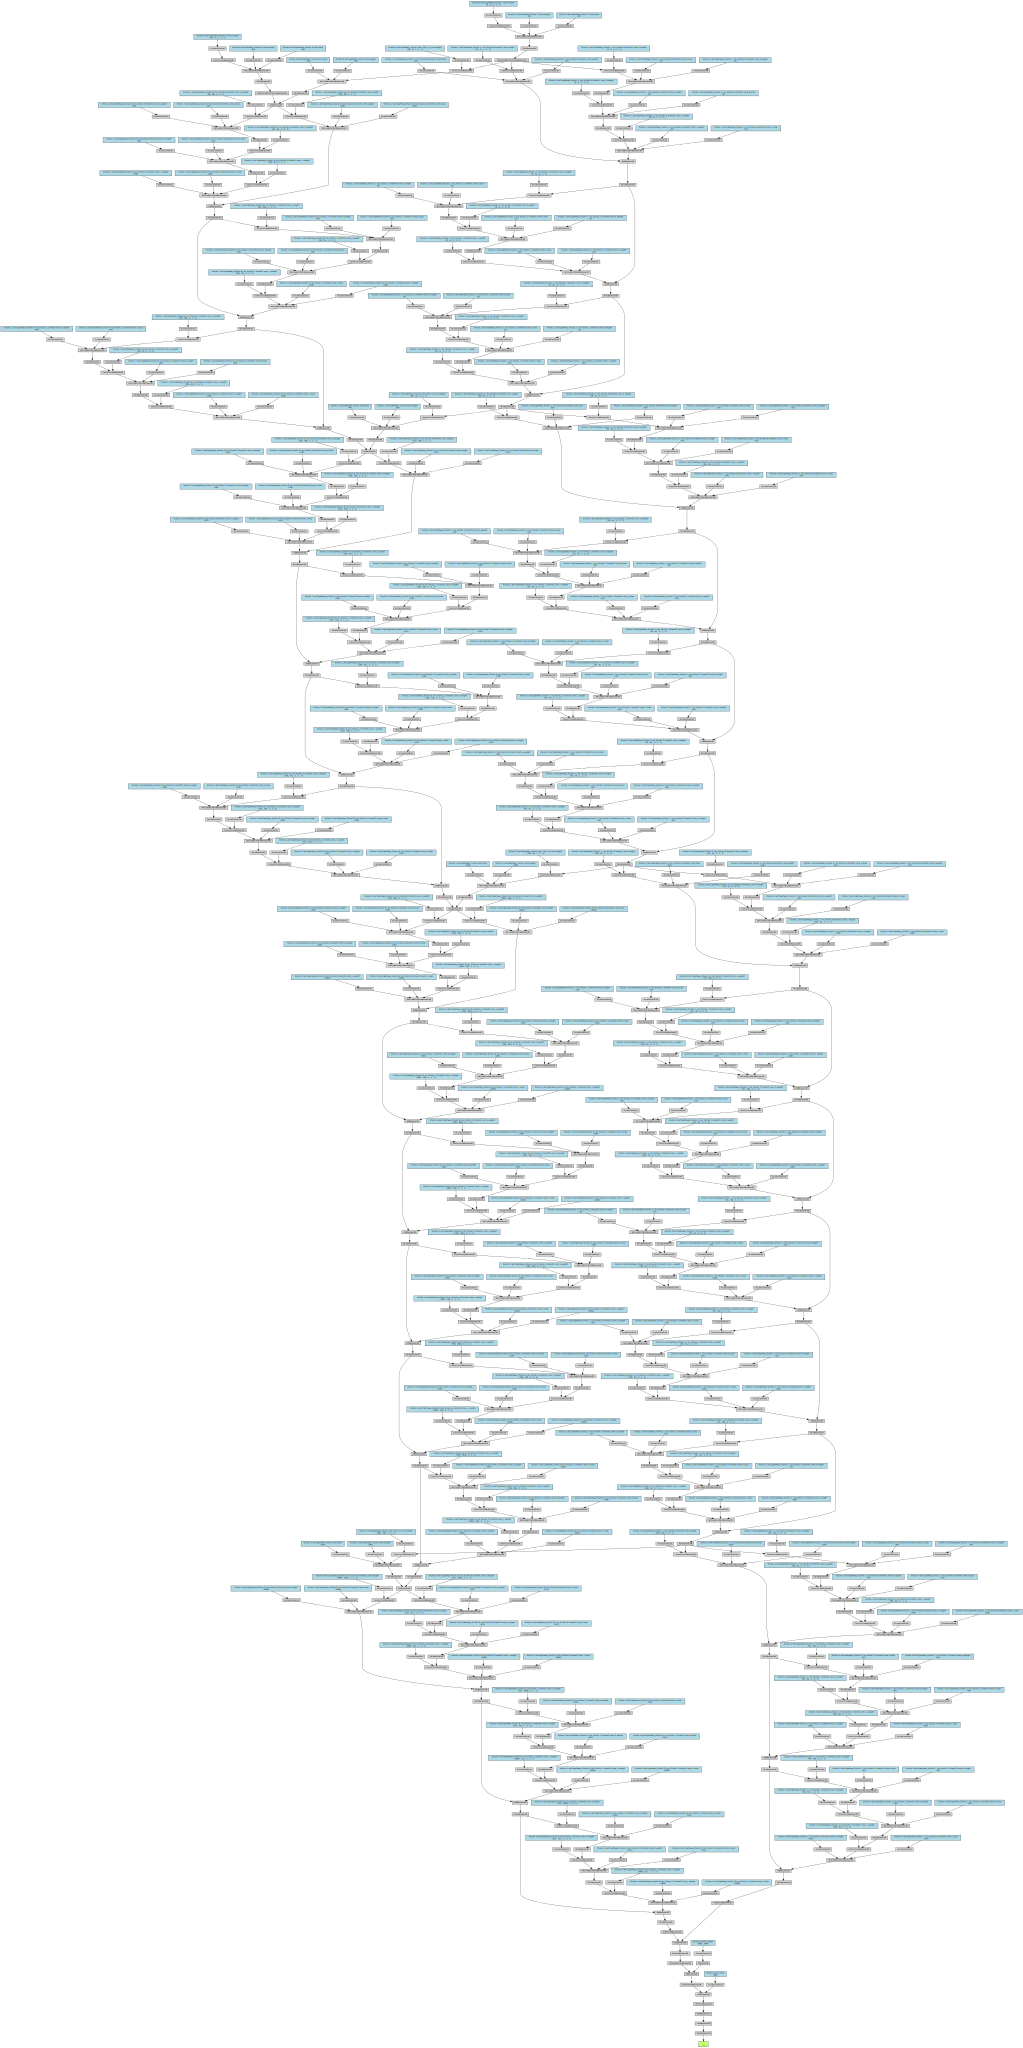

In [ ]:
make_dot(preds.mean(), params=dict(model.named_parameters()))

In [ ]:
post_act = torch.nn.Softmax(dim=1)
preds = post_act(preds)
pred_classes = preds.topk(k=1).indices
print(pred_classes)
# Map the predicted classes to the label names
pred_class_names = [kinetics_id_to_classname[int(i)] for i in pred_classes[0]]
print("Predicted labels: %s" % ", ".join(pred_class_names))

tensor([[179]])
Predicted labels: krumping


In [ ]:
pred_classes

tensor([[179]])

In [ ]:
print(classification_report(pred_classes[0], pred_classes[0]))

              precision    recall  f1-score   support

         179       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1



In [ ]:
# torch.save(model.state_dict(), "/content/model.pt")